100%|██████████| 50/50 [01:11<00:00,  1.44s/it]


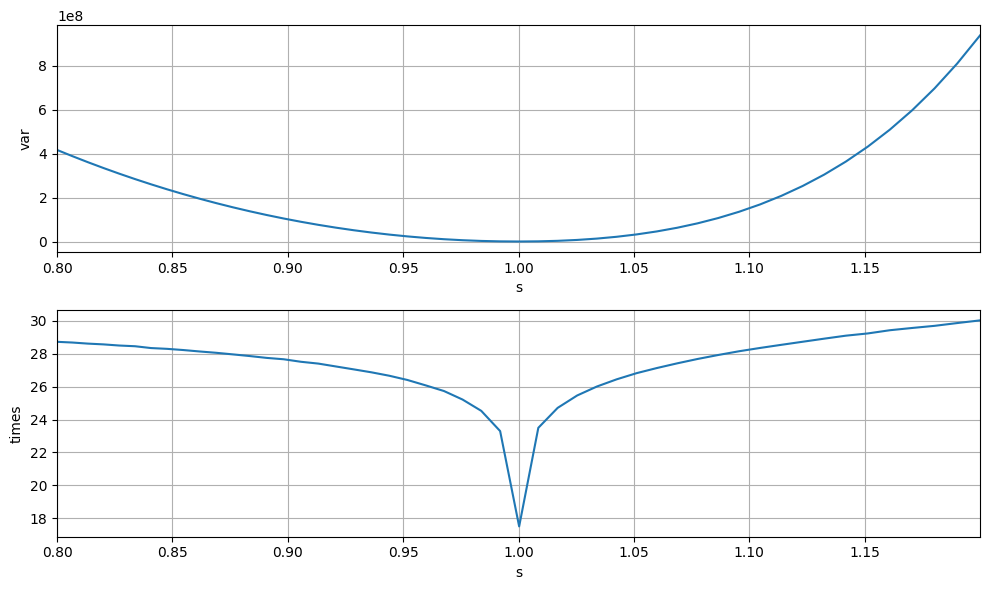

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

np.random.seed(616)

# 读取npy文件
try:
    data = np.load('../data/B/init_positions.npy')
except FileNotFoundError:
    print("文件不存在")

# params
n = data.shape[0]                       # 智能体数量
p = 0.1                                 # 伯努利分布概率
threshold = 1e-2                        # 收敛条件
max_iterations = 1000                   # 最大迭代次数
num_simulations = 10000                 # 模拟次数
delta = 0.1                             # delta参数
epsilon = 0.1                           # epsilon参数
alpha = 1e-6                            # alpha参数
epsilon_matrix = epsilon * np.ones(n)   # epsilon矩阵形式
alpha_matrix = alpha * np.ones(n)       # alpha矩阵形式

# 构建邻接矩阵
A = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        if (np.random.binomial(1, p) + np.random.binomial(1, p)):
            A[i, j] = 1
            A[j, i] = 1

D = np.diag(A.sum(axis=1))              # 节点度矩阵
L = D - A                               # 邻接矩阵的拉普拉斯矩阵
d_max = D.max().item()                  # 节点度最大值
h = 0.99 / d_max                        # h参数
theta0 = np.random.normal(50, 10, n)    # 初始状态

def phi(alpha, s):
    a = s ** 2 * (alpha + (1 - alpha) * abs(s - 1)) ** 2
    b = (alpha ** 2 * (1 - abs(s - 1)) ** 2) * (1 - (alpha + (1 - alpha) * abs(s - 1)) ** 2)
    
    if b == 0:
        return np.nan
    return a / b

def simulation_single(theta0, c, A, B, q):
    theta = theta0.copy()
    convergence = False
    q_powered = 1
    for k in range(max_iterations):
        b = c * q_powered
        eta = np.random.laplace(scale=b, size=n)
        next_theta = A @ theta + B @ eta

        if np.max(np.abs(next_theta - theta)) < threshold:
            convergence = True
            theta = next_theta
            break
        theta = next_theta
        q_powered *= q

    return (k if convergence else max_iterations), theta

def simulate_s(s):
    q = alpha + (1 - alpha) * abs(s - 1)
    c = (delta * q) / (epsilon * (q - abs(s - 1)))
    A = np.eye(n) - h * L
    B = s * np.eye(n) - h * L

    results = Parallel(n_jobs=-1, verbose=0)(
        delayed(simulation_single)(theta0, c, A, B, q)
        for _ in range(num_simulations)
    )

    convergece_times = [res[0] for res in results]
    Js = [np.max(res[1]) for res in results]
    # J = (2 / n) * (delta ** 2 / epsilon ** 2) * phi(alpha, s)
    J = (2 / n) * ((s ** 2 * c **2) / (1 - q ** 2))

    return np.mean(convergece_times), J

if __name__ == '__main__':
    s_values = np.logspace(np.log10(0.8), np.log10(1.2), 50)
    # s_values = np.linspace(0.8, 1.2, 50)
    times, vs = [], []

    for s in tqdm(s_values):
        t, var = simulate_s(s)
        times.append(t); vs.append(var)

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(s_values, vs, label='var')
    plt.xlabel('s'); plt.ylabel('var')
    plt.xlim(0.8, 1.2); plt.grid(True)
    plt.xticks(np.arange(0.8, 1.2, 0.05))

    plt.subplot(2, 1, 2)
    plt.plot(s_values, times, label='times')
    plt.xlabel('s'); plt.ylabel('times')
    plt.xlim(0.8, 1.2); plt.grid(True)
    plt.xticks(np.arange(0.8, 1.2, 0.05))

    plt.tight_layout()
    plt.show()
    